# 0.0 IMPORTS

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import inflection
import math
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as Grid
import datetime

from scipy                  import stats as ss
from IPython.core.display   import HTML
from IPython.display        import Image
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

# updating libs: pip freeze > requirements.txt 

## 0.1 Helper Functions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()    
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2correction = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorrection = k - (k-1)**2/(n-1)
    rcorrection = r - (r-1)**2/(n-1)

    #Crumer V
    return np.sqrt( (chi2correction/n) / (min( kcorrection-1, rcorrection-1)) )


## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [4]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

## 1.1 Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [9]:
print(f'Number of rowns {df1.shape[0]}')
print(f'Número of columns {df1.shape[1]}')

Number of rowns 1017209
Número of columns 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].fillna(int(200000))

#competition_open_since_month
# Same month as Date columns
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# #promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1 :'Jan', 2 :'Feb',3 :'Mar',4 :'Apr',5 :'May',6 :'Jun',7 :'Jul',8 :'Aug',9 :'Sep',10 :'Oct',11 :'Nov',12 :'Dec'}
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 
    0 if x['promo_interval'] == 0 
    else 
        1 if x['month_map'] in x['promo_interval'].split( ',') 
        else 0, 
        axis=1)


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [14]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64)

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [18]:
# Split dataset in numerics or categorical columns
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [19]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
265743,451,7,0,0,0,0,0,2460.0,4,2009,1,13,2010,0
341873,929,3,4675,665,1,0,0,4820.0,9,2013,0,37,2014,0


In [20]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
654633,0,c,c,"Mar,Jun,Sept,Dec",Nov
650905,0,a,c,0,Nov


In [21]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


## 1.7.1 Numerical Attributes

In [22]:
# Central Tendency - mean, medians
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

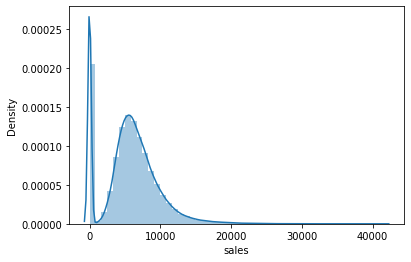

In [23]:
sns.distplot( df1['sales'])

c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

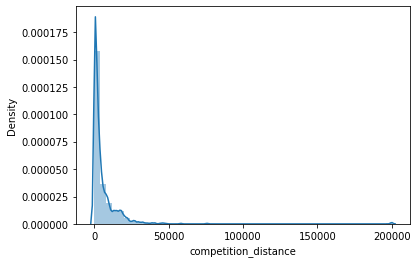

In [24]:
sns.distplot( df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

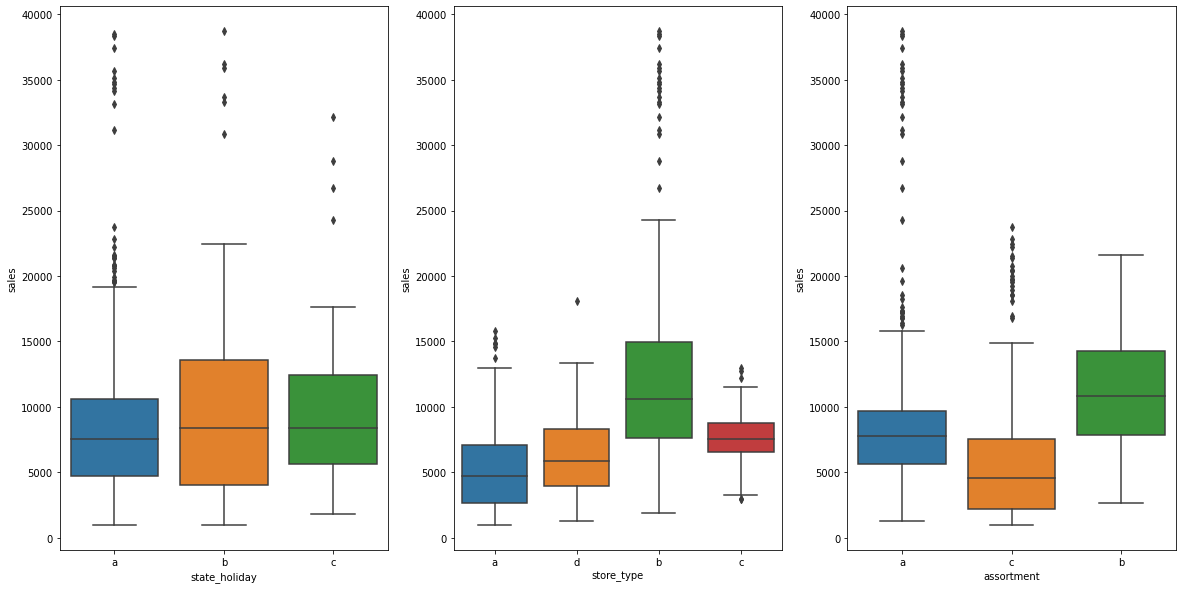

In [26]:
plt.figure(figsize=(20,10))
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1)
sns.boxplot(x= 'state_holiday',y='sales' ,data=aux1)

plt.subplot( 1, 3, 2)
sns.boxplot(x= 'store_type',y='sales' ,data=aux1)

plt.subplot( 1, 3, 3)
sns.boxplot(x= 'assortment',y='sales' ,data=aux1)

# 2.0 FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Mindmap Hypothesis

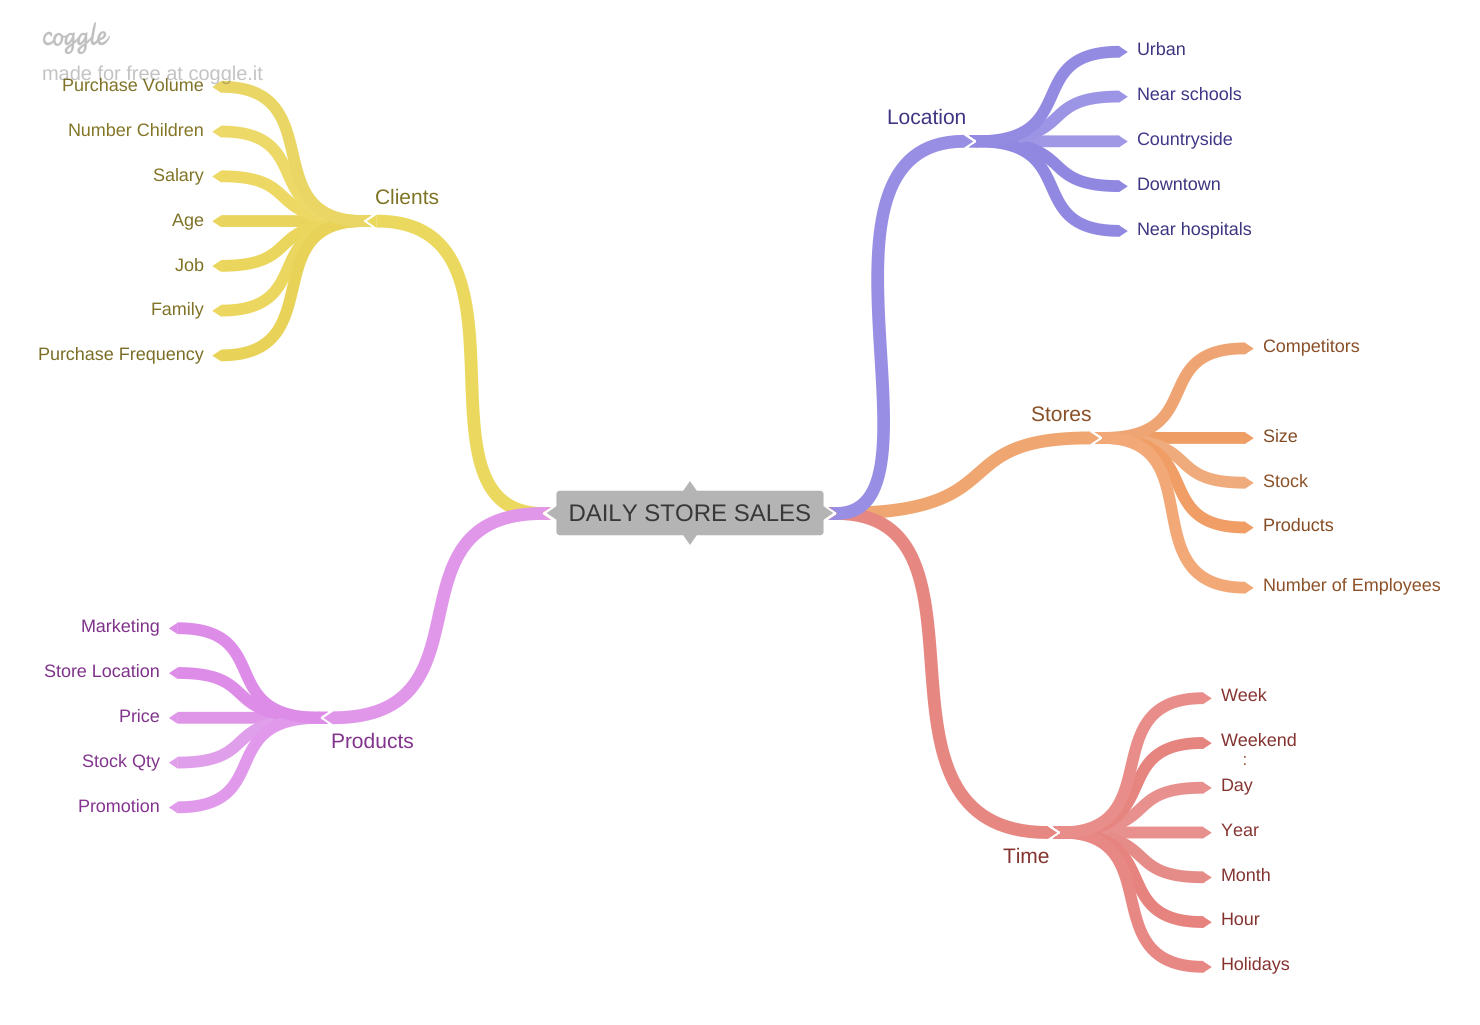

In [28]:
Image( 'img/MindMapHypotesis.png')

### 2.1.1 Hypothesis related to store

**1.** Stores with more employess, sell more

**2.** Stores with more stock probably, sell more

**3.** Stores with larger space, sell more

**4.** Stores with small space, sell less

**5.** Stores with more products available, sell more

**6.** Stores with more competition nearby sell less

**7.** Stores with competition for a longer time sell more

### 2.1.2 Hypothesis related to product

**1.** Stores with higher investment in Marketing, sell more

**2.** Stores with a better product disposition, probably sell more

**3.** Stores with cheaper prices, are more likely to sell more

**4.** Stores with active promotions for a longer period sell more

**5.** Stores with more days of promotions sell more

**6.** Stores with more promotion in a row sell morective promotions for a longer period sell more

### 2.1.3 Hypothesis related to Period

**1.** Stores open during Christmas sell more

**2.** Stores are more likely to sell more as years go by

**3.** Stores are more likely to improve sales in second semester

**4.** Stores sell more after day 10 of each month

**5.** Stores have a better selling result in weekends

**6.** Stores face a decrease on sales during school holidays

## 2.2 Final Hypothesis List

Based on the data we have right now, we select tbe hypothesis that can be answered.

**1.** Stores with more products available, sell more

**2.** Stores with more competition nearby sell less

**3.** Stores with competition for a longer time sell more


**4.** Stores with active promotions for a longer period sell more

**5.** Stores with more days of promotions sell more

**6.** Stores with more promotion in a row sell morective promotions for a longer period sell more

**7.** Stores open during Christmas sell more

**8.** Stores are more likely to sell more as years go by

**9.** Stores are more likely to improve sales in second semester

**10.** Stores sell more after day 10 of each month

**11.** Stores have a better selling result in weekends

**12.** Stores face a decrease on sales during school holidays


## 2.3 Feature Engineering

In [29]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/ 30).apply( lambda x: x.days ).astype(np.int64)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(np.int64)
# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a'
    else 'extra' if x == 'b' 
    else 'extended')
# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' 
    else  'easter_holiday' if x == 'b' 
    else 'christmas' if x == 'c' 
    else 'regular_day')

In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


**Filtrar variáveis**: relacionado à restrições do negócio. (Qual limites os times tem antes da gente conseguir colocar os dados no modelo)
 
**Seleção variáveis**: relacionado à variáveis relevantes para o modelo.

# 3.0 VARIABLES FILTERING

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Lines filtering

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [34]:
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS EDA

**Exploratory Data Analysis (EDA)**

How these variables impact the phenomenum

What is the variables impact

**3 EDA goals**
1. Gain experience about the business

2. Validate hypothesis about the business (insight)

3. Understand which variables are important to the model

**3 types of analysis**
1. Univariate Analysis
- The variable shape (min, max, distribution)

2. Bivariate Analysis
- How this variable impacts the answer (correlation, hypothesis validation)

3. Multivariate Analysis
- How variable relate to each other

In [36]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

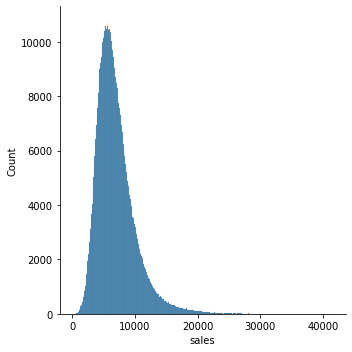

In [37]:
sns.displot(df4['sales']);

### 4.1.2 Numerical Variables

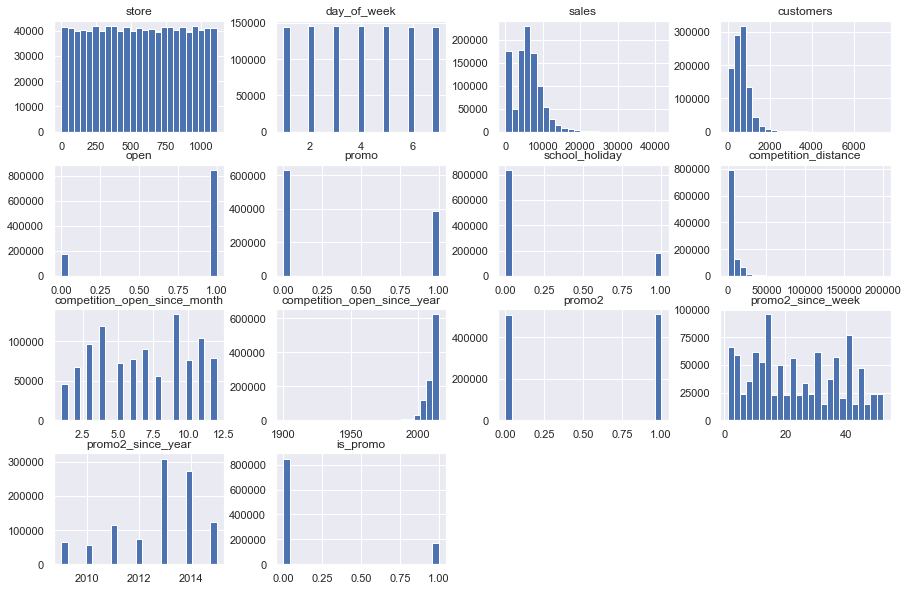

In [38]:
sns.set(rc={'figure.figsize':(15,10)})
num_attributes.hist(bins=25)
plt.show()

**Graphics explanation**
.....

### 4.1.3 Categorical Variables

In [39]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an exp

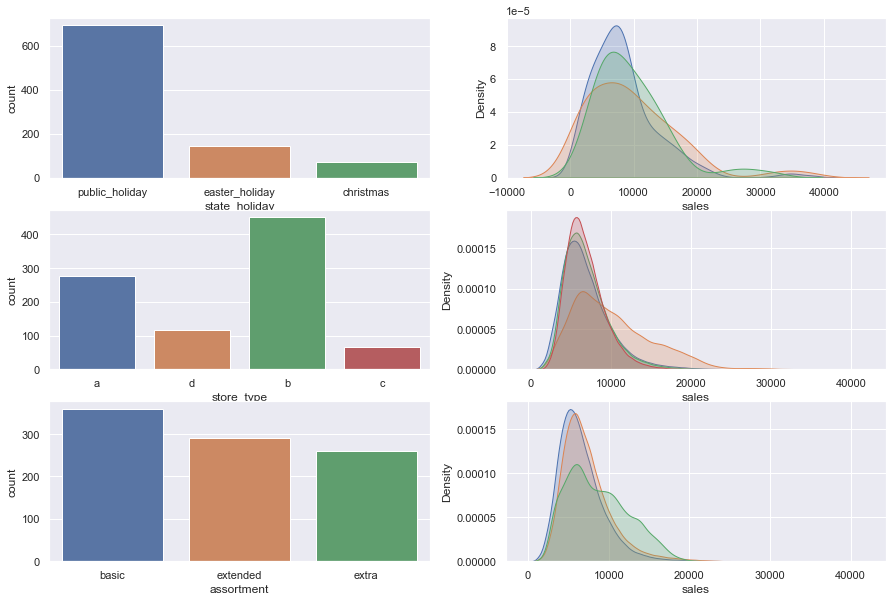

In [40]:
# state_holiday
plt.subplot(3,2,1)
holidays = df4[df4['state_holiday']  != 'regular_day']
sns.countplot(holidays['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True);

# store_type
plt.subplot(3,2,3)

sns.countplot(holidays['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',shade=True);

# assortment
plt.subplot(3,2,5)

sns.countplot(holidays['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True);

plt.show()

## 4.2 Bivariate Analysis

### **H1.** Stores with more products available, sell more
***FALSE***: With this analysis we can identify that stores with less products available have better numbers. Stores with Extra is the smallest one.

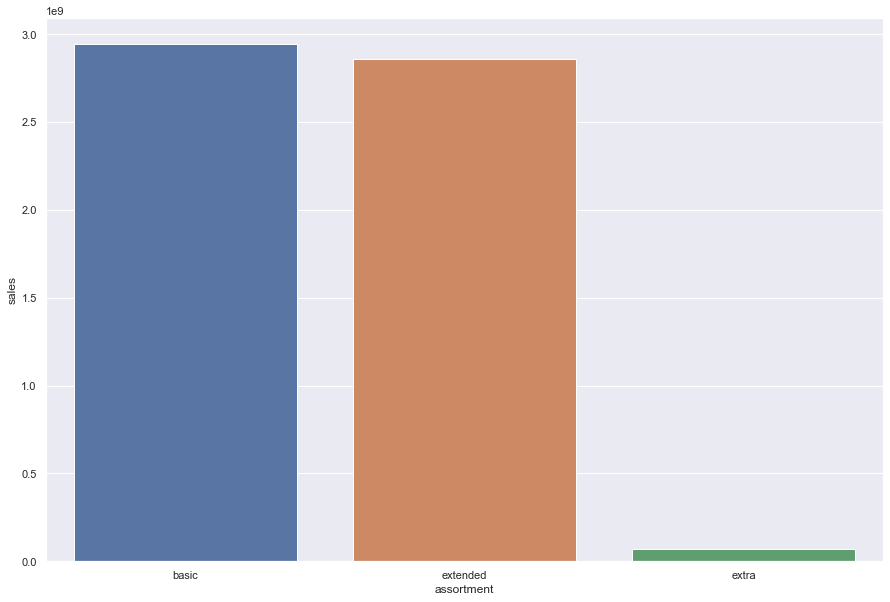

In [41]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);
plt.show()

<AxesSubplot:xlabel='year_week'>

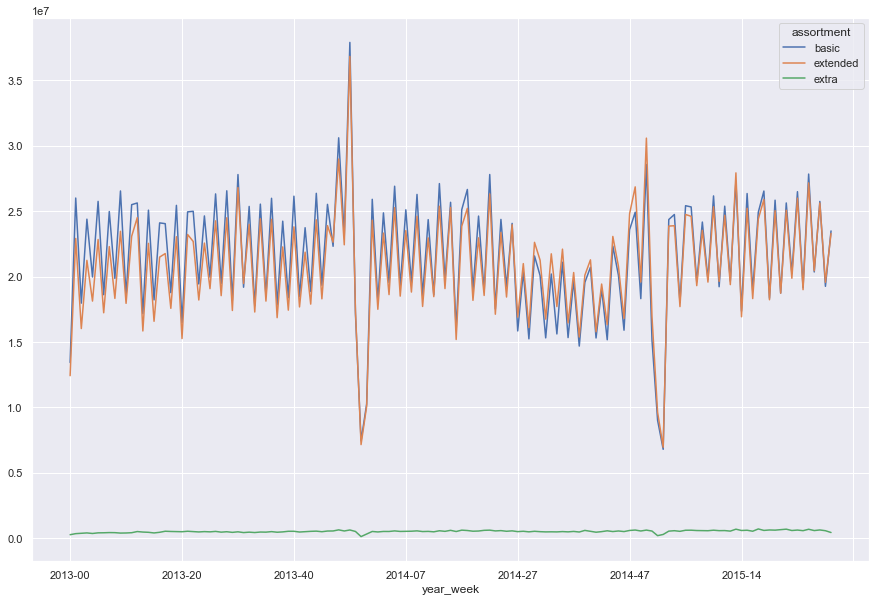

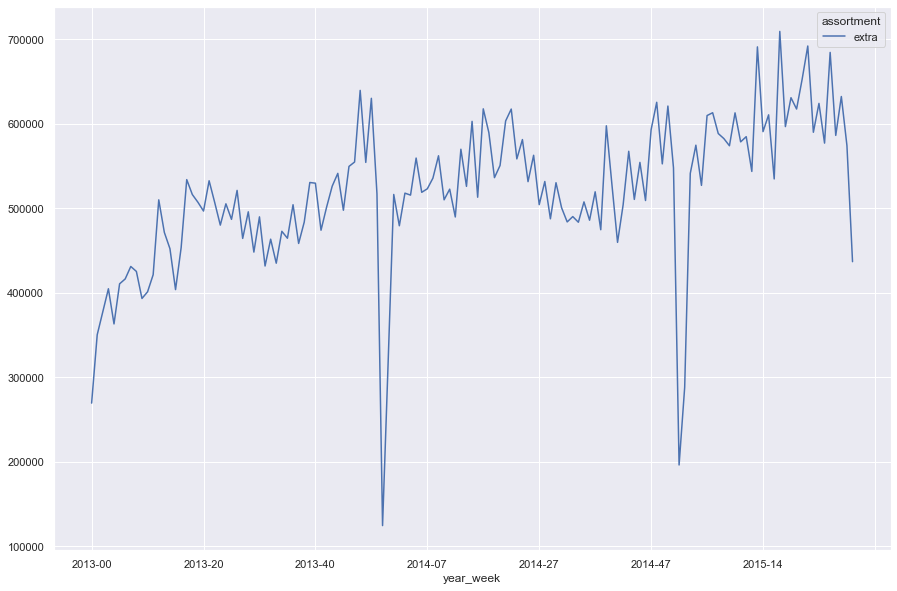

In [42]:
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

### **H2.** Stores with more competition nearby sell less
***FALSE***: All stores with neaby competition are presenting a better sales result.

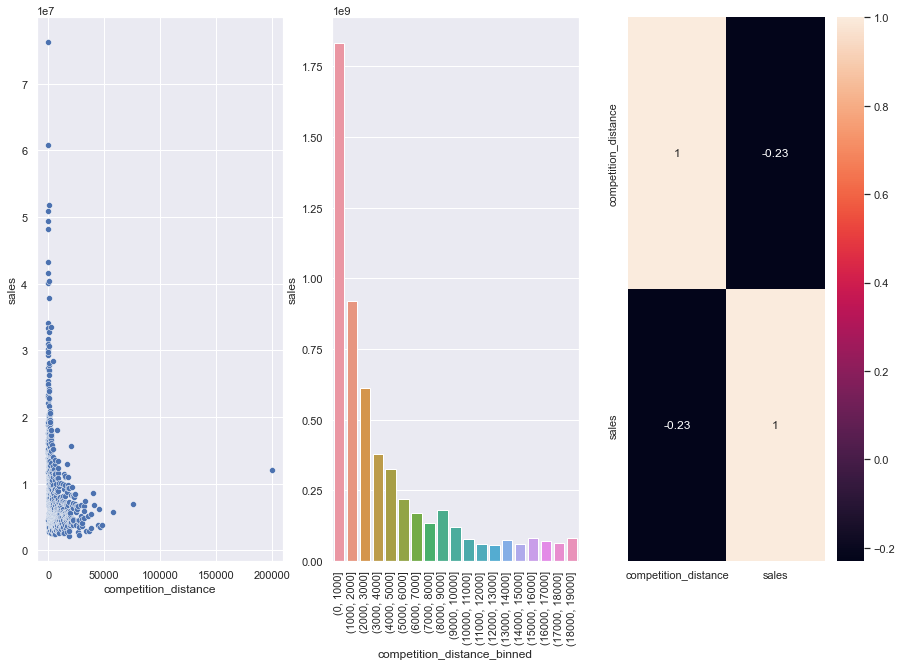

In [43]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

### **H3.** Stores with competition for a longer time sell more
***FALSE***: The numbers show that this is not true as stores that have had competition for longer period, usually sell less than others

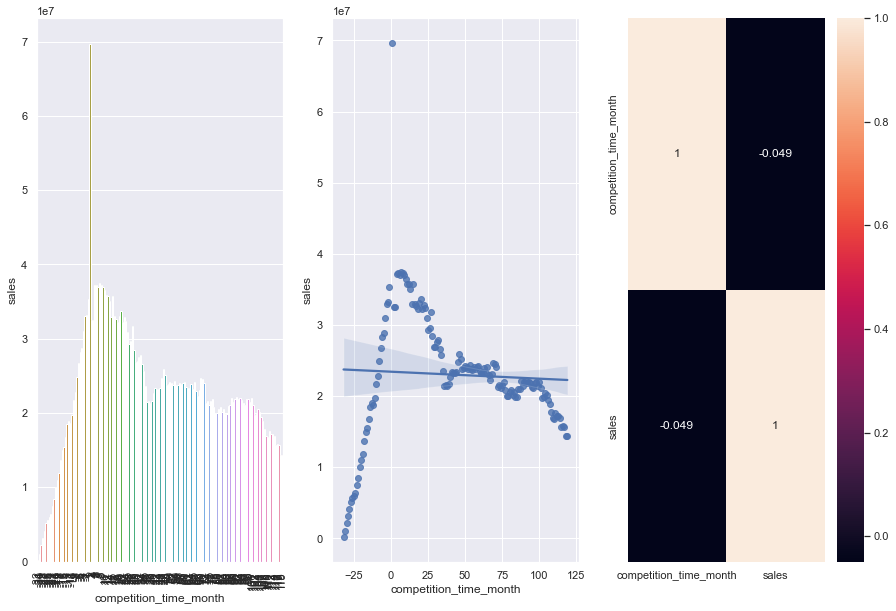

In [44]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.xticks(rotation=90)
sns.barplot(x = 'competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True)
plt.show()

### **H4.** Stores with active promotions for a longer period sell more
***FALSE***: Stores with promotion for a longer period actually have a lower sales result if compared to other stores

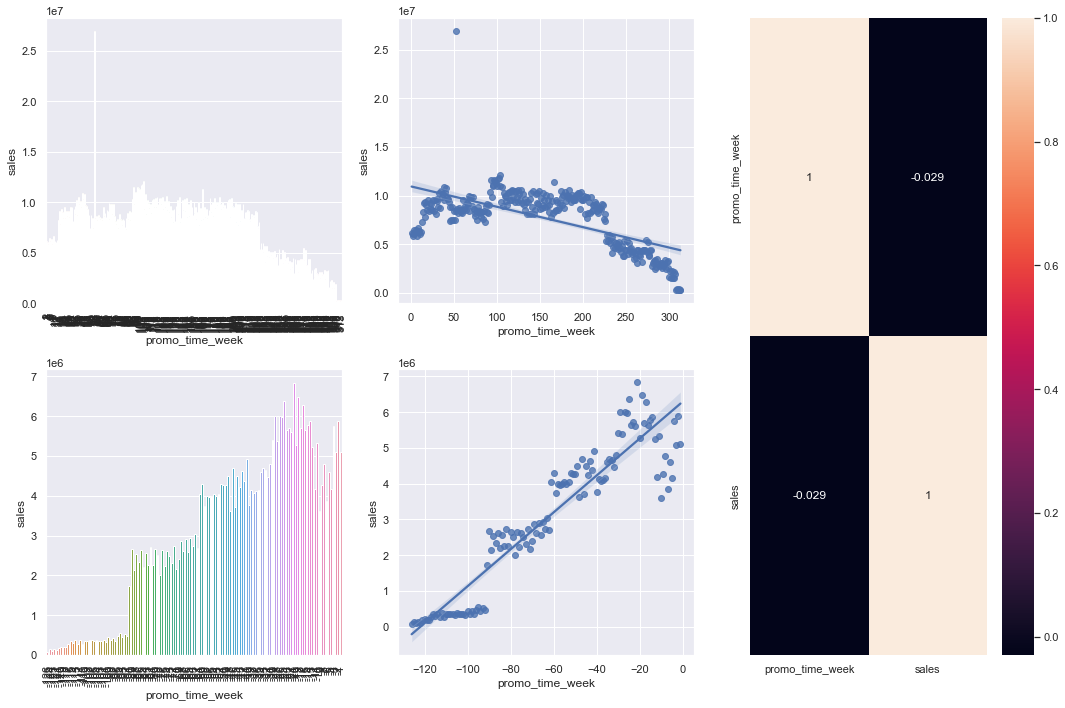

In [45]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# sns.barplot(x='promo_time_week', y='sales', data=aux1)
grid = Grid.GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.tight_layout()
plt.show()

### <s> **H5.** Stores with more days of promotions sell more </s>

### **H6.** Stores with more consecutive promotion sell more
***FALSE***: Longer periods of promotion are usually resulting on a decrease on sales

In [46]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


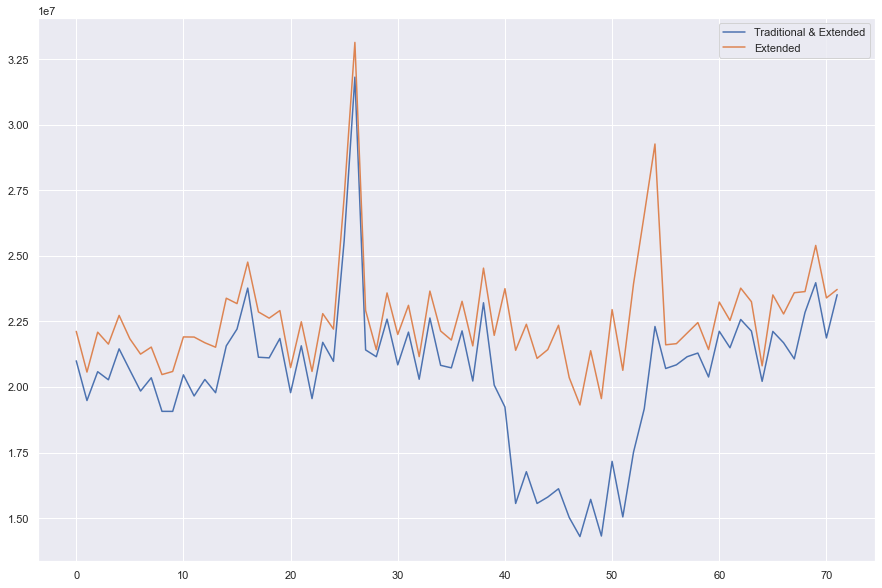

In [47]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend( labels = ["Traditional & Extended", "Extended"])

### **H7.** Stores open during Christmas sell more
**FALSE** Christmas period have a smaller result if compared to other holidays

<AxesSubplot:xlabel='year', ylabel='sales'>

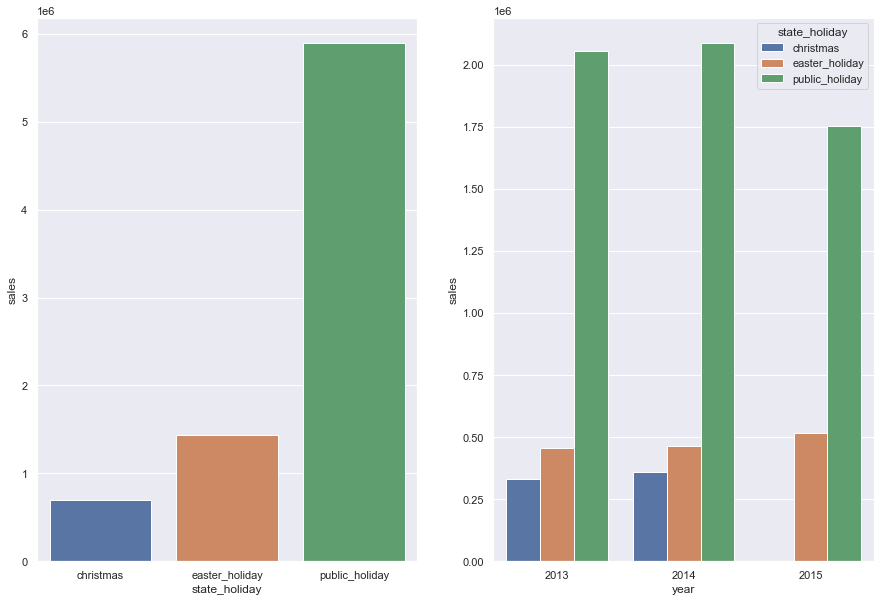

In [48]:

# df4.head()
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != "regular_day"]
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday',data=aux2)

### **H8.** Stores are more likely to sell more as years go by
**False** As per year result, the total sales is decreasing

<AxesSubplot:>

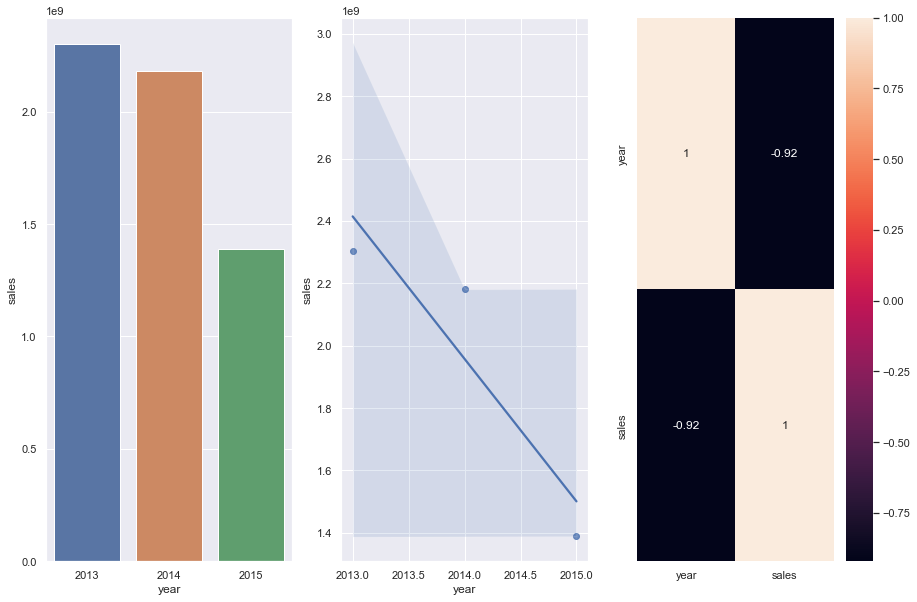

In [49]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9.** Stores are more likely to improve sales in second semester
**False** From July to December, the numbers are significantly smaller than the first half of the year.

<AxesSubplot:>

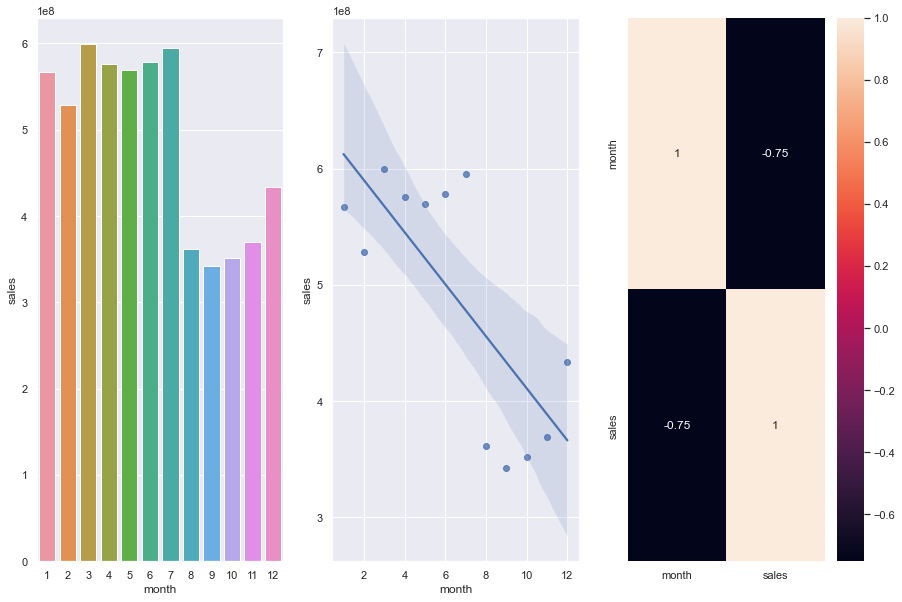

In [50]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10.** Stores sell more after day 10 of each month
**False** Although number are slightly higher, the result is not enough to confirm this hypothesis

<AxesSubplot:xlabel='before_after', ylabel='sales'>

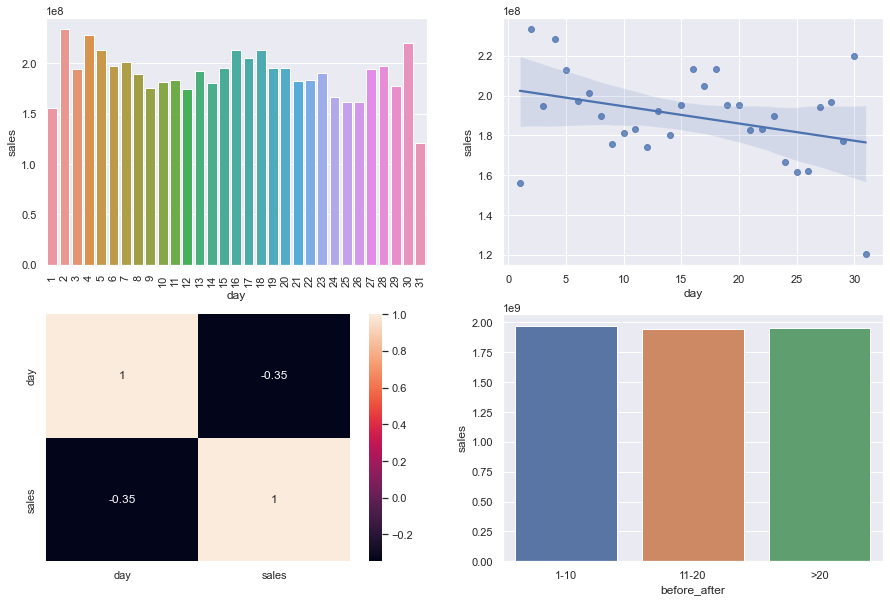

In [51]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(
    lambda x: '1-10' if x <= 10 else ( 
        '11-20' if x > 10 and x <=20 
        else '>20'))


aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)



### **H11.** Stores have a worse selling result on weekends
**True** Stores have lower sales results on weekends

<AxesSubplot:>

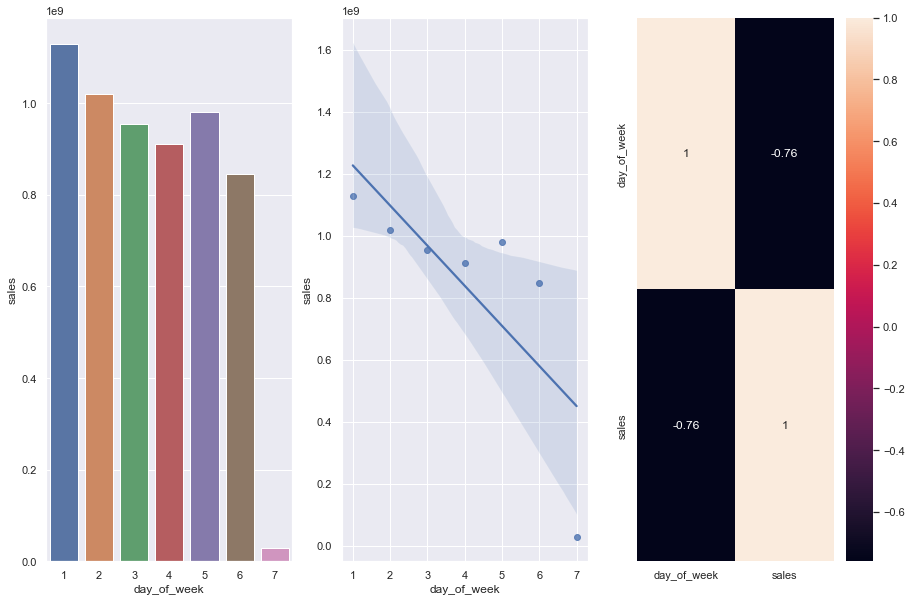

In [52]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H12.** Stores face a decrease on sales during school holidays
**True** Stores face a decrease during school holidays, except in July and August

<AxesSubplot:>

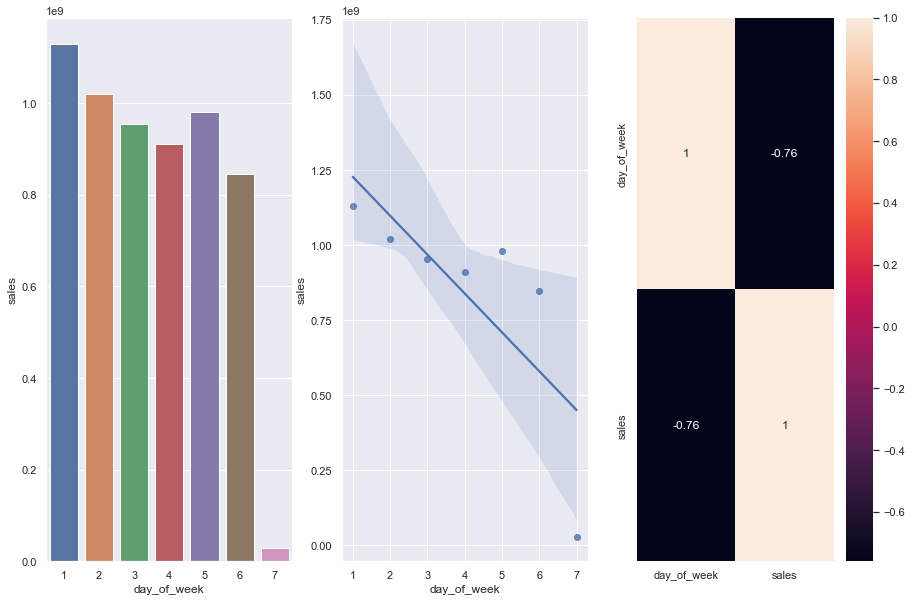

In [53]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

<AxesSubplot:>

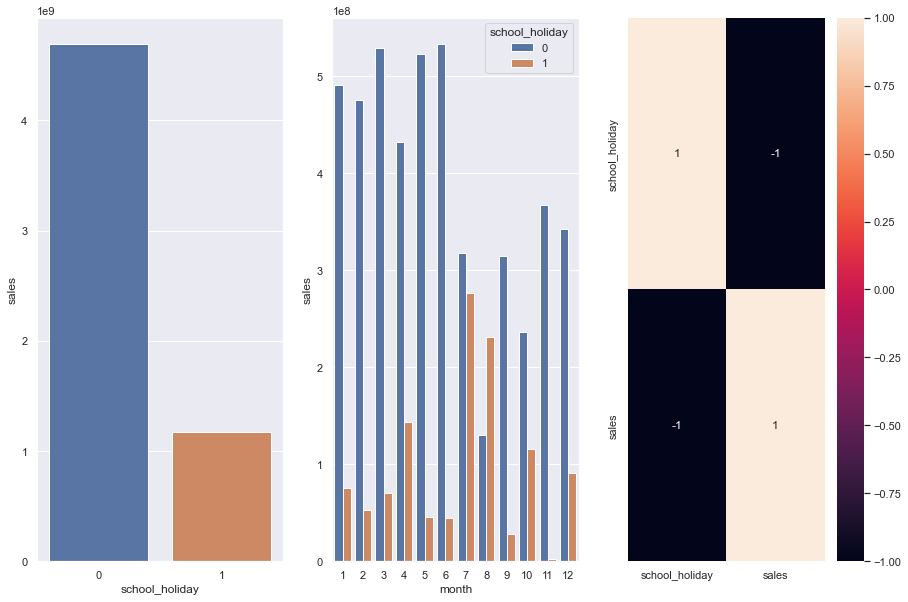

In [54]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.2.1 Hypothesis resume

In [55]:
from tabulate import tabulate

In [56]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
['H1','False','Low'],
['H2','False','Medium'],
['H3','False','Medium'],
['H4','False','Low'],
['H5','-','-'],
['H7','False','Low'],
['H8','False','Medium'],
['H9','False','High'],
['H10','False','High'],
['H11','True','High'],
['H12','True','High']]

print(tabulate(tab, headers='firstrow'))



Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H7            False         Low
H8            False         Medium
H9            False         High
H10           False         High
H11           True          High
H12           True          High


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

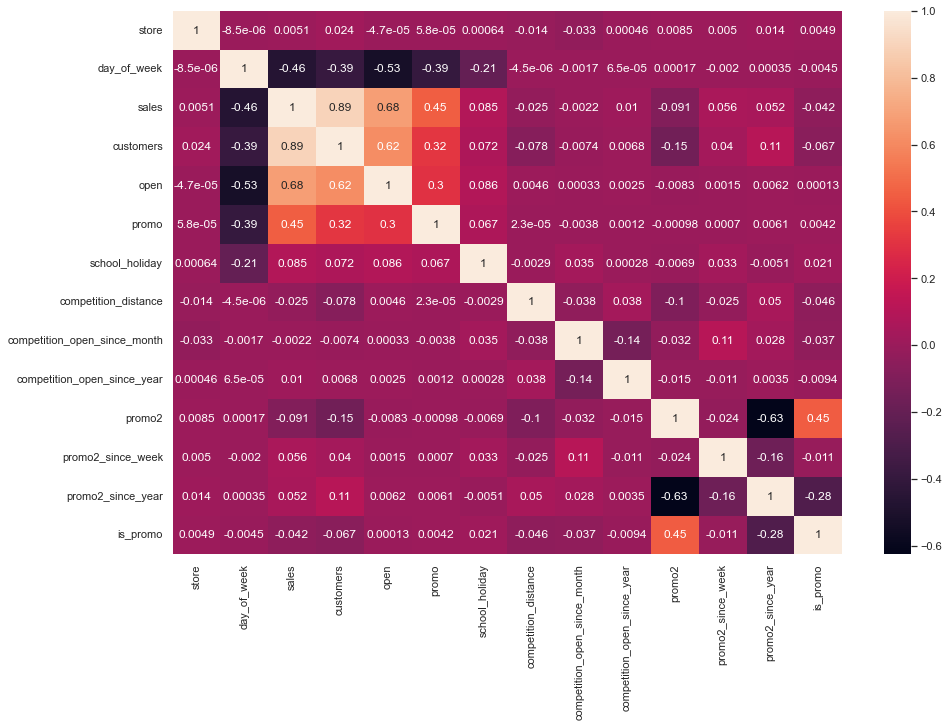

In [57]:
correlation = num_attributes.corr( method = 'pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorial Attributes

<AxesSubplot:>

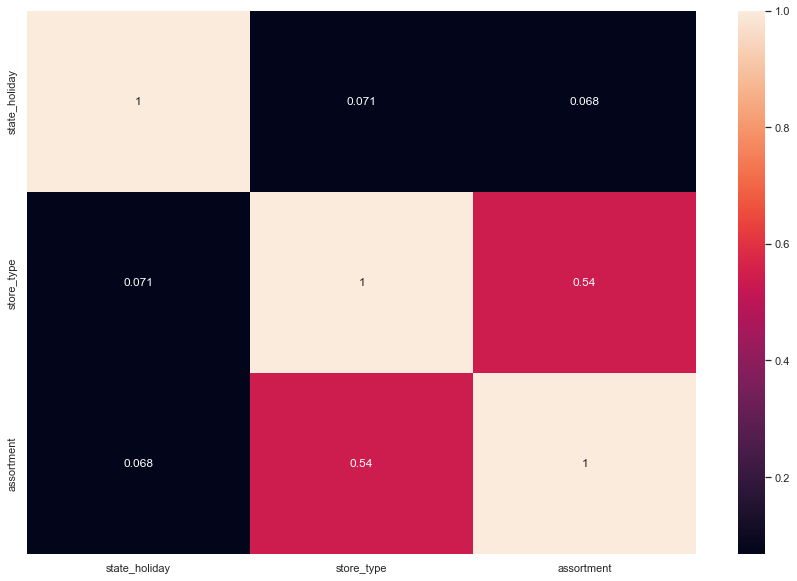

In [58]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculatin Cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# Final dataset
d = pd.DataFrame( 
    {'state_holiday':[a1,a2,a3],
    'store_type':[a4,a5,a6],
    'assortment':[a7,a8,a9],
    })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 DATA PREPARATION

**Data Modeling**

Most ML codes are improved by using numeric variables. If they are in the same base it will improve the result even more.

**3 types of Data Modeling**
1. Normalizing - Make sure all results are within a range from 0 to 1

2. Rescaling - Make sure all results are within a range from 0 to 1. Also it's very effective fr variables that don't have a Gaussian distribution

3. Transformation - Conversion from Categorical to Numerical (Encoding) and Nature Transformation.


In [77]:
df5 = df4.copy()

## 5.1 Normalization

**Normalization has a better performance on variables with normal distribution. In this dataset there is none ,therefore in order to avoid using an incorrect result, we will not normalize any.**

## 5.2 Rescaling

**Min-Max Scaler - can be used when dataset does not have big outliers** 

Calculation: ( (Variable - Mean) / (VariablesMax - VariablesMin) )

**Robust Scaler - can be used when dataset  have big outliers** 

Calculation: ( (Variable - Quartile1) / (Quartile3 - Quartile1) )

In [60]:
rs = RobustScaler()
mms = MinMaxScaler()

# CHOSEN COLUMNS
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform(df5[['year']].values )

## 5.3 Transformation

### 5.3.1 Encoding

**Types of Encoding - Only way of checking if they work is by testing all of them in your dataset**
1. One Hot Enconding - Turn variables into columns and fill them with 1 whenever match, otherwise place as 0. Pros: Easy to apply // Cons: Too many columns are created, enlarging dataset size
2. Label Encoding - Similar to One Hot Encoding but with numbers for each variable. 
3. Ordinal Encoding - Similar to label but ordered by some logical hierarchy 
4. Target Encoding - Works fine with more than 100 options. It uses the mean of each option.
5. Frequency Encoding - Count how many "sales" happened in each option.
6. Embedding Encoding - Frequently used with NLP and neural networks.

In [62]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [63]:
# df5.select_dtypes(include='object')
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {
    'basic':1, 
    'extra': 2,
    'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


**Types of Transformation**
1. Logarithm Transformation - When log is applied, numbes are shifter and closer to normal
2. Box-Cox Transformation - Also organize variables to be closer to normal
3. Cube-Root Transformation 
4. Square-Root Transformation
5. Sine and Cosine Transformation

### 5.3.2 Response Variable Transformation

In [65]:
df5['sales'] = np.log1p( df5['sales'])

c:\Users\vinicius.sousa\Desktop\github\DSemProd\venvDSemProd\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

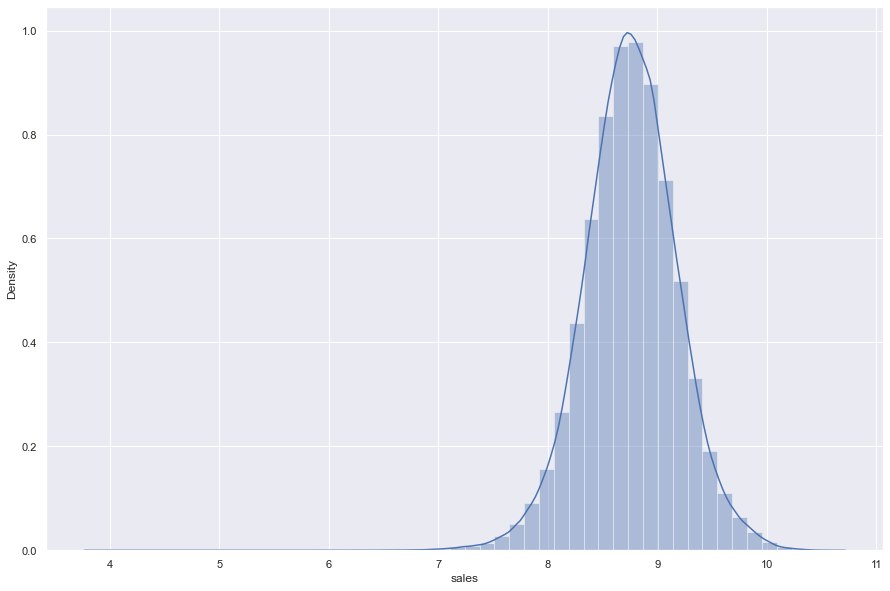

In [66]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [78]:
# CHOSEN COLUMNS 2 -  Cyclic variables
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin ( x * (2 * np.pi / 7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos ( x * (2 * np.pi / 7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin ( x * (2 * np.pi / 12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos ( x * (2 * np.pi / 12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin ( x * (2 * np.pi / 30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos ( x * (2 * np.pi / 30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin ( x * (2 * np.pi / 52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos ( x * (2 * np.pi / 52) ) )

In [79]:
df5

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
